# gwexpy Tutorial: Frequency Domain Extensions

This notebook demonstrates the new features added to `gwexpy.frequencyseries.FrequencySeries` in Phase 1.

## 1. Setup

Import necessary libraries and `gwexpy`.

In [1]:
#%matplotlib inline
#from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats("svg")
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline", force=True)

import sys
from pathlib import Path

# Allow `import gwexpy` when running this notebook from `examples/`.
cwd = Path.cwd().resolve()
for p in [cwd, *cwd.parents]:
    if (p / "gwexpy").is_dir():
        p_str = str(p)
        if p_str not in sys.path:
            sys.path.insert(0, p_str)
        break

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt

from gwexpy.frequencyseries import FrequencySeries



## 2. Phase and Group Delay

gwexpy now supports direct phase extraction and group delay calculation.
Let's simulate a signal with a pure time delay: $S(f) = e^{-j 2\pi f \tau}$.

/home/washimi/mambaforge/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/washimi/mambaforge/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


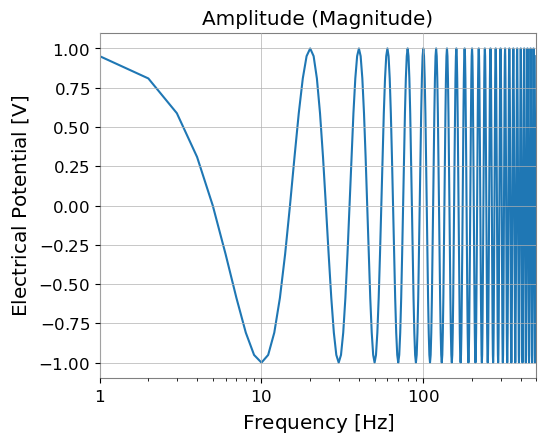

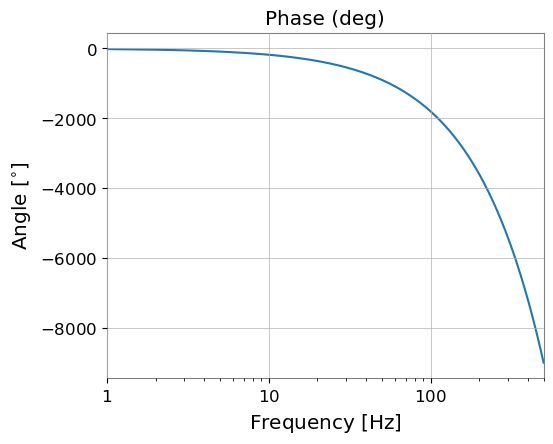

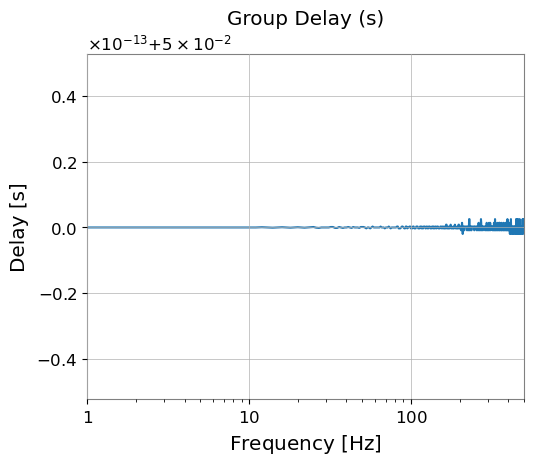

In [2]:
# Create data
df = 1.0
f = np.arange(0, 500, df)
tau = 0.05  # 50 ms delay

val = np.exp(-1j * 2 * np.pi * f * tau)
fs = FrequencySeries(val, frequencies=f, unit='V', name='Delay Signal')

# Calculate Phase (radians and degrees)
phase_rad = fs.phase(unwrap=True)
phase_deg = fs.degree(unwrap=True)

# Calculate Group Delay
gd = fs.group_delay()

# Plot
plot = fs.plot(title="Amplitude (Magnitude)")
plot.show()

plot_p = phase_deg.plot(title="Phase (deg)")
plot_p.show()

plot_g = gd.plot(title="Group Delay (s)", ylabel="Delay [s]")
plot_g.show()

## 3. Time Differentiation & Integration

You can perform time-domain calculus in the frequency domain.
- `differentiate_time()`: Displacement -> Velocity
- `integrate_time()`: Velocity -> Displacement

/home/washimi/mambaforge/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


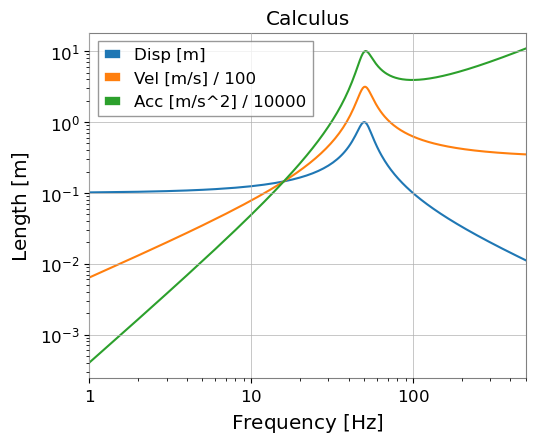

In [8]:
# Create a simple resonance-like peak in Displacement
f0 = 50.0
val_disp = 1.0 / (1 + 1j * (f - f0)/5.0)
disp = FrequencySeries(val_disp, frequencies=f, unit='m', name='Displacement')

# Convert to Velocity and Acceleration
vel = disp.differentiate_time()
acc = vel.differentiate_time()

vel.name = 'Velocity'
acc.name = 'Acceleration'

# Plot magnitudes
plot = disp.abs().plot(label='Disp [m]', title="Calculus")
ax = plot.gca()
ax.plot(vel.frequencies, vel.abs().value / 100, label='Vel [m/s] / 100')
ax.plot(acc.frequencies, acc.abs().value / 10000, label='Acc [m/s^2] / 10000')
ax.set_yscale('log')
ax.legend()
plot.show()

## 4. Analysis Tools: Smoothing, dB, Quadrature Sum

Tools for noise analysis and budgeting.

Noise A: 1.0, Noise B: 2.0
Total (Sqrt Sum): 2.23606797749979


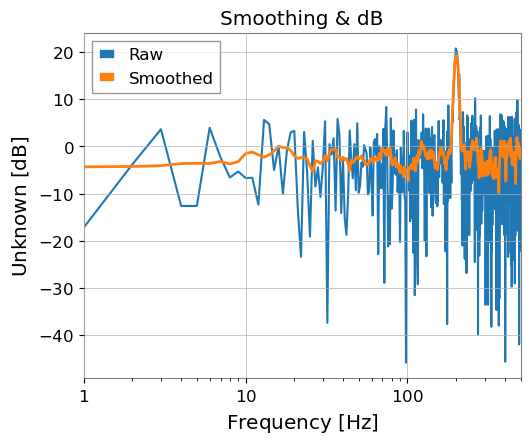

In [4]:
# Generate noisy data
np.random.seed(42)
noise = np.abs(np.random.randn(len(f)))
peak = 10.0 * np.exp(-(f - 200)**2 / 50.0)
data = noise + peak

raw = FrequencySeries(data, frequencies=f, unit='V', name='Raw Data')

# Smooth
smoothed = raw.smooth(width=10, method='amplitude')
smoothed.name = 'Smoothed'

# Convert to dB
raw_db = raw.to_db()
smoothed_db = smoothed.to_db()
raw_db.name = 'Raw (dB)'
smoothed_db.name = 'Smoothed (dB)'

plot = raw_db.plot(label='Raw', title="Smoothing & dB")
ax = plot.gca()
ax.plot(smoothed_db.frequencies, smoothed_db.value, label='Smoothed', linewidth=2)
ax.legend()
plot.show()

# Quadrature Sum (Noise Budget example)
noise_a = FrequencySeries(np.ones_like(f), frequencies=f, unit='V', name='Noise A')
noise_b = FrequencySeries(np.ones_like(f) * 2, frequencies=f, unit='V', name='Noise B')

total = noise_a.quadrature_sum(noise_b)
print(f"Noise A: {noise_a.value[0]}, Noise B: {noise_b.value[0]}")
print(f"Total (Sqrt Sum): {total.value[0]}")